# 基于实例的迁移

基于实例的迁移学习研究的是，如何从源领域中挑选出，对目标领域的训练有用的实例，比如对源领域的有标记数据实例进行有效的权重分配，让源域实例分布接近目标域的实例分布，从而在目标领域中建立一个分类精度较高的、可靠地学习模型。
因为，迁移学习中源领域与目标领域的数据分布是不一致，所以源领域中所有有标记的数据实例不一定都对目标领域有用。

![](基于实例的迁移.png)

TrAdaBoost算法就是典型的基于实例的迁移。在一个包含源域训练数据和目标域样本的训练集中，TrAdaBoost算法会对训练样本进行权重调整。对于目标域样本，如果被错误分类，根据目标域样本的分类错误率进行调整，增加其权重，使得下次训练时更关注这些被错分的目标域样本。对于源域样本，当其被误分类后，TrAdaBoost算法则认为其与目标数据不同分布的，因此会降低其权重。

# 一、建模场景

## 1.1 业务场景

某金融公司在新场景下展开小额现金贷产品，积累了少量有标签样本，样本量不足以用于建模。考虑到虽然场景不同，但借款用户的本质上比较相似，所以对原有大额产品的存量客户进行迁移。首先制作4个在旧业务上表现较好的特征，同时要保证原有场景的存量客户与目标场景都有此特征，且特征含义一致。

## 1.2 建模方法

将知识从原有场景的样本（源域）迁移至只有少量样本的新场景客群（目标域）。
在此，TrAdaBoost算法采用逻辑回归作为基模型，并使用单模型进行最终的预判，使得最终的模型可以保留线性模型的解释性，以适应于更多实际业务

# 二、导入数据

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score,roc_curve,auc  
from sklearn.model_selection import train_test_split  
from sklearn import metrics  
from sklearn.linear_model import LogisticRegression  
from sklearn.svm import LinearSVC  
import random
import math
from sklearn.calibration import CalibratedClassifierCV

# 忽略warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
data = pd.read_csv('./tra_sample.csv') 

In [4]:
data.head()

,zx_score,msg_cnt,phone_num_cnt,register_days,bad_ind,type
0,-0.322581,0.023810,0.00,0.217949,0,target
1,0.078853,0.023810,0.02,0.461538,0,target
2,0.078853,0.071429,0.00,0.217949,0,target
3,-0.128677,0.023810,0.00,0.217949,0,target
4,-0.261014,0.071429,0.05,0.217949,0,target


In [4]:
data['type'].unique()

array(['target', 'origin', 'offtime'], dtype=object)

- 特征：'zx_score', 'msg_cnt', 'phone_num_cnt', 'register_days'
- 标签：'bad_ind'
- 分类：标识具体每一条样本属于'target'目标域， 'origin'源域， 'offtime'时间外样本集

In [5]:
feature_lst = ['zx_score', 'msg_cnt', 'phone_num_cnt', 'register_days']

# 三、数据处理

## 3.1 划分目标域、源域、时间外样本集

In [6]:
train = data[data.type == 'target'].reset_index().copy()
diff = data[data.type == 'origin'].reset_index().copy()
val = data[data.type == 'offtime'].reset_index().copy() 

In [7]:
train = train.loc[:1200]

In [8]:
trans_s = train[feature_lst].copy() # 目标域样本
label_s = train['bad_ind'].copy() # 目标域标签

trans_a = diff[feature_lst].copy() # 源域样本
label_a = diff['bad_ind'].copy() # 源域标签

In [9]:
val_x = val[feature_lst].copy()
val_y = val['bad_ind'].copy()

In [10]:
test = val_x.copy()

## 3.2 通过LR对目标域少量样本进行拟合

In [11]:
lr_model = LogisticRegression(C=0.1,class_weight = 'balanced',solver = 'liblinear')
lr_model.fit(trans_s,label_s)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
y_pred = lr_model.predict_proba(trans_s)[:,1]

In [13]:
fpr_lr_train,tpr_lr_train,_ = roc_curve(label_s,y_pred)

In [14]:
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks :',train_ks)

train_ks : 0.48500238435860754


In [15]:
y_pred = lr_model.predict_proba(test)[:,1] 

In [16]:
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks :',val_ks)

val_ks : 0.3887057754389137


训练集和时间外样本集KS相差超过10%（行业要求5%）

单独模型的模型表现

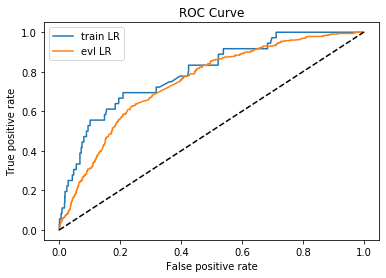

In [19]:
from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')  
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

ROC曲线非常不稳定，模型泛化能力较差

## 3.3 整合源域数据和目标域数据，用LR进行拟合

In [17]:
trans_data = np.concatenate((trans_a,trans_s), axis=0)
trans_label = np.concatenate((label_a,label_s), axis=0)

In [18]:
lr_model = LogisticRegression(C=0.3,class_weight = 'balanced',solver = 'liblinear')
lr_model.fit(trans_a,label_a)

LogisticRegression(C=0.3, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
y_pred = lr_model.predict_proba(trans_data)[:,1]
fpr_lr_train,tpr_lr_train,_ = roc_curve(trans_label,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks :',train_ks)

train_ks : 0.4910909493184976


In [20]:
y_pred = lr_model.predict_proba(test)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks :',val_ks)

val_ks : 0.33077621830414


整体建模的模型表现

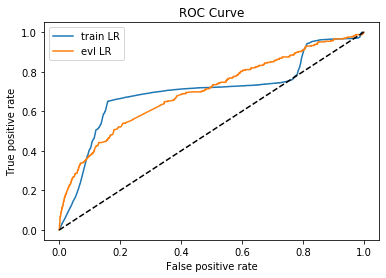

In [24]:
from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')  
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

时间外样本集ROC曲线曲率较低，且训练集ROC曲线波动剧烈，说明模型的区分能力和泛化能力都差。

# 四、模型训练

构造新的TrAdaBoost算法，对数据集进行训练，得到最优模型

In [21]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

In [22]:
def Tr_lr_boost(trans_a,trans_s,label_a,label_s,test,label_test,
                N=500,
                early_stopping_rounds =100):
    
    # 计算weight
    def calculate_P(weights,label):
        total = np.sum(weights)
        return np.asarray(weights / total, order='C')
    
    # 用逻辑回归作为基分类器，输出概率
    def train_classify(trans_data, trans_label, test_data, P):
        clf = LogisticRegression(C=0.3,class_weight = 'balanced',solver='liblinear')
        clf.fit(trans_data, trans_label, sample_weight=P[:,0])
        return clf.predict_proba(test_data)[:,1],clf
    
    # 计算目标域上的错误率
    def calculate_error_rate(label_R, label_H, weight):
        total = np.sum(weight)
        return np.sum(weight[:,0] / total * np.abs(label_R - label_H))
    
    # 根据逻辑回归的score得到标签（不能用predict直接输出标签）
    def put_label(score_H,thred):
        new_label_H = []
        for i in score_H:
            if i <= thred:
                new_label_H.append(0)
            else:
                new_label_H.append(1)
        return new_label_H
    
    # 指定迭代次数，相当于集成模型中基模型的数量
    

    # 拼接数据集
    trans_data = np.concatenate((trans_a,trans_s), axis=0)
    trans_label = np.concatenate((label_a,label_s), axis=0)
    
    # 三个数据集样本数
    row_A = trans_a.shape[0]
    row_S = trans_s.shape[0]
    row_T = test.shape[0]
    
    # 三个数据集合并为打分数据集
    test_data = np.concatenate((trans_data, test), axis=0)
    
    # 初始化权重 
    weights_A = np.ones([row_A, 1])/row_A
    weights_S = np.ones([row_S, 1])/row_S*2
    weights = np.concatenate((weights_A, weights_S), axis=0)
    
    # 按照公式初始化beta值
    beta = 1 / (1 + np.sqrt(2 * np.log(row_A / 500)))
    
    beta_T = np.zeros([1,500])
    
    # 存储每次迭代的标签
    result_label = np.ones([row_A + row_S + row_T, 500])
    
    '''
    500 =N 迭代次数
    '''

    trans_data = np.asarray(trans_data, order='C')
    trans_label = np.asarray(trans_label, order='C')
    test_data = np.asarray(test_data, order='C')
    
    # 最优ks值
    best_ks = -1
    # 最优基模型数量
    best_round = -1
    # 最优模型
    best_model = -1
    
    '''
    初始化结束    
    正式开始训练
    '''

    N = 500
    for i in range(N):
        P = calculate_P(weights, trans_label)
        result_label[:,i],model = train_classify(trans_data, trans_label,
                                                test_data, P)
        score_H = result_label[row_A:row_A + row_S, i]
        pctg = np.sum(trans_label)/len(trans_label)
        thred = pd.DataFrame(score_H).quantile(1-pctg)[0]
        label_H = put_label(score_H,thred)
        
        # 计算在目标域上的错误率
        error_rate = calculate_error_rate(label_s, label_H,
                                         weights[row_A:row_A + row_S, :])
        # 防止过拟合
        if error_rate > 0.5:
            error_rate = 0.5
        if error_rate == 0:
            N = i
            break
        # 存每一次迭代的beta值 = error_rate / (1 - error_rate)
        beta_T[0,i] = error_rate / (1 - error_rate)
        
        # 调整目标域样本权重
        for j in range(row_S):
            weights[row_A + j] = weights[row_A + j] * np.power(beta_T[0,i],
                                (-np.abs(result_label[row_A + j, i] - label_s[j])))
        # 调整源域样本权重
        for j in range(row_A):
            weights[j] = weights[j] * np.power(beta,
                                              np.abs(result_label[j, i] - label_a[j]))
        y_pred = result_label[(row_A + row_S):,i]
        fpr_lr_train,tpr_lr_train,_ = roc_curve(label_test,y_pred)
        train_ks = abs(fpr_lr_train - tpr_lr_train).max()
        train_ks
        #print('train_ks :', train_ks)
            
        # 不再使用后一半学习器投票，而是只保留效果最好的逻辑回归模型  
        if train_ks > best_ks:
            best_ks = train_ks
            best_round = i
            best_model = model
        # 当超过eadrly_stopping_rounds轮KS不再提升后，停止训练
        if best_round < i - early_stopping_rounds:
            break
    return best_ks,best_round,best_model    

In [23]:
# 训练并得到最优模型
best_ks,best_round,best_model = Tr_lr_boost(trans_a,trans_s,label_a,label_s,
                                            test,label_test=val_y,N=300,
                                            early_stopping_rounds=20) 

# 五、模型评价

使用最优的逻辑回归模型对样本进行测试

In [24]:
y_pred = best_model.predict_proba(trans_s)[:,1]
fpr_lr_train,tpr_lr_train,_ = roc_curve(label_s,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
train_ks = train_ks.max()
train_ks
#print('train_ks :', train_ks)

0.4629947544110634

In [26]:
y_pred = best_model.predict_proba(test)[:,1]  
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)  
val_ks = abs(fpr_lr - tpr_lr).max()  
print('val_ks : ',val_ks)  

val_ks :  0.39846160021324123


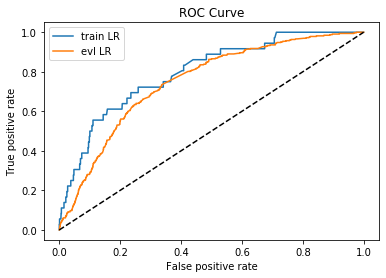

In [24]:
from matplotlib import pyplot as plt  
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')  
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')  
plt.plot([0,1],[0,1],'k--')  
plt.xlabel('False positive rate')  
plt.ylabel('True positive rate')  
plt.title('ROC Curve')  
plt.legend(loc = 'best')  
plt.show() 